# Proyecto Final
### Axel Casas Espinosa <axew@ciencias.unam.mx>

## Genómica Computacional - 2024I


Buscamos datos en el 'NCBI GEO Datasets', para encontrar un dataset con información de los pacientes de distrofía muscular DMD, y así poder analizar los datos y encontrar patrones que nos ayuden a entender mejor la enfermedad.

Fue una tarea más que complicada, por la gran cantidad de datasets que existen, y la poca información que se encuentra en ellos, finalmente encontramos, que aunque reducido, nos permitía realizar un análisis de los datos. 

El dataset que encontramos fue el siguiente: [GSE199659] (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE199659)

Además ocupamos la secuencia del gen DMD para poder realizar el análisis de los datos, [DMD dystrophin  Homo sapiens (human)] (https://www.ncbi.nlm.nih.gov/gene/1756)


In [2]:
#Se requiere instalar biopython
pip install biopython


Note: you may need to restart the kernel to use updated packages.


In [22]:
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# Leer las secuencias del archivo
dmd_records = list(SeqIO.parse('DMD_GENE.fna', 'fasta'))

# Si solo quieres trabajar con la primera secuencia del archivo, puedes hacerlo así:
dmd = dmd_records[0]

# Mostrar los primeros 1000 nucleótidos en el gen DMD
dmd_DNA = dmd.seq
print(dmd_DNA[:1000])


def nt_search(seq, start_codon, stop_codon):
    orfs = []
    start_positions = [i for i in range(len(seq)) if seq.startswith(start_codon, i)]
    
    for start in start_positions:
        for i in range(start, len(seq), 3):
            if seq[i:i+3] == stop_codon:
                orfs.append(seq[start:i+3])
                break
                
    return orfs

# Número de ORFs (Open Reading Frames) viables
orfs_all = nt_search(str(dmd_DNA), 'ATG', 'TGA') # TGA es el codón de paro para DMD (Distrofina), 
                                                 # pero puede variar para otras secuencias   
                                                 
# Número de ORFs no espurios con probabilidad < 0.05
orfs_05 = [orf for orf in orfs_all if len(orf) >= 150 and len(orf) % 3 == 0]

# Número de ORFs no espurios con probabilidad < 0.01
orfs_01 = [orf for orf in orfs_all if len(orf) >= 180 and len(orf) % 3 == 0]

# Imprimir resultados
print(f"a) Número de ORFs viables: {len(orfs_all)}")
print(f"b) Número de ORFs no espurios con probabilidad < 0.05: {len(orfs_05)}")
print(f"c) Número de ORFs no espurios con probabilidad < 0.01: {len(orfs_01)}")

# Código para obtener el número de ORFs reales y compara con los resultados anteriores
# Utilizando ORFfinder:
# - Guarda la secuencia en un archivo FASTA
with open('sequence_dmd.fasta', 'w') as fasta_file:
    SeqIO.write(dmd, fasta_file, 'fasta')

# - Utilizando ORFfinder en línea: https://www.ncbi.nlm.nih.gov/orffinder/
# - archivo __all.fa contiene los resultados de ORFfinder
orfs_reales = []
with open('dmd__all.fa', 'r') as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith(">"):
            orfs_reales.append(line)
print(f"e) Número de ORFs reales: {len(orfs_reales)}")

GGCAGTAATAGAATGCTTTCAGGAAGATGACAGAATCAGGAGAAAGATGCTGTTTTGCACTATCTTGATTTGTTACAGCAGCCAACTTATTGGCATGATGGAGTGACAGGAAAAACAGCTGGCATGGAAGGTAGGATTATTAAAGCTATTACATCATTACAAATACAATTAGAAGCTGGCCATGACAAAGCATATGTTTGAACAAGCAGCTGTTGGTAGCTGGGGTTTGTTGCCGAGCTCTTCAAACTCTGCAAACAGTGTTGCTTTTACAGAATGGATTTTAAAATTGCCTTGTGCTGCGTTAGATTTTGGGGAGGGGGTGTGCTTGCCTCCAACCTCAGGAAAACACTTCTGGGATAGAAATCAGTGTTAGAAGATTTTAGAATAAAGTATTGTTCAGGAGTCTAGGTTTCTTCAGGTAGATGATGACAGGGGGAAAAAAATCTTCGGGGAAATCTACCCCAGATTAGTTATATGCAATTTAGTTGCAAGAACTGATTGATGTATTGGCATATTCAGACAGTGAGAGAAATGAGAATGTACAGAATGTTTGGATAGGTTGAAAATTGTTATACTTGGTTTCTATTTTATAAGGAGTTTGGCTGTCAGTCATTTCTCCTCATCAATTTCTAGCTTTTGACATTTATTCAGTCATTCTGCATTATATGAAGAAAATATATCAATATCTCCTGCAGGGTTTTTCAACAACTCTAGCATCTGTTTCAGCTATTGAACTGTATTCACGTTTTGCCAAGTTGATGTCGACCCAGCTGGTCTATGATTTCTCGCTTGATTACTGCTCTTAATTTCTCTGTATCAGCTTGTTTCAGATAGGGCTTTGAAGGCTGTTAATGAAAAATGACAGAAGTGATAAATTATTGAAAATGTGAGCATTTATTTATTTATTTATTTATTTATTTATTTATTTTGCCCTTTAATGAGTTTTGTCTTACATTCTTTCTTGCCTGCGTACGATTTTTAGAACCCTTTCTCTGTTTTG

In [27]:
# Red neuronal para clasificar e identificar ADN del gen DMD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Leer el archivo de datos
df = pd.read_csv('dmd.csv')

# Eliminar las filas con valores faltantes
df.dropna(inplace=True)

# Separar las características de las etiquetas
X = df.drop('pk', axis=1)
y = df['ck']

# Convertir datos categoricos a numéricos
le = LabelEncoder()
X = X.apply(le.fit_transform)

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Crear el modelo de red neuronal
model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=5000, alpha=0.0001, solver='adam', 
                      random_state=21, tol=0.000000001, batch_size=64, learning_rate_init=0.001)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir las etiquetas de los datos de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.10256410256410256
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


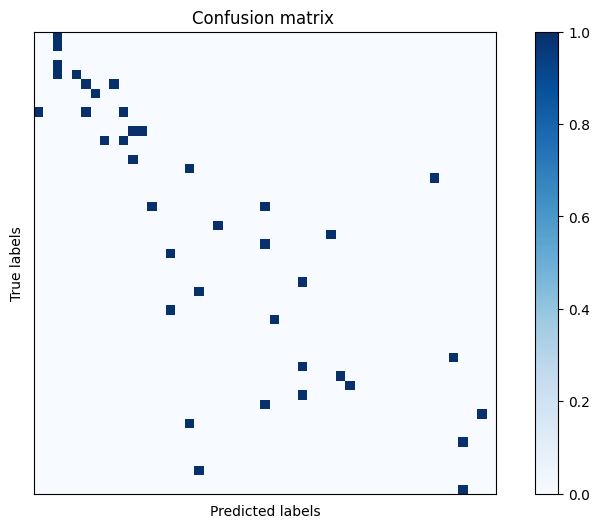

In [28]:
# Mostrar la matriz de confusión en una gráfica
plt.figure(figsize=(10, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()


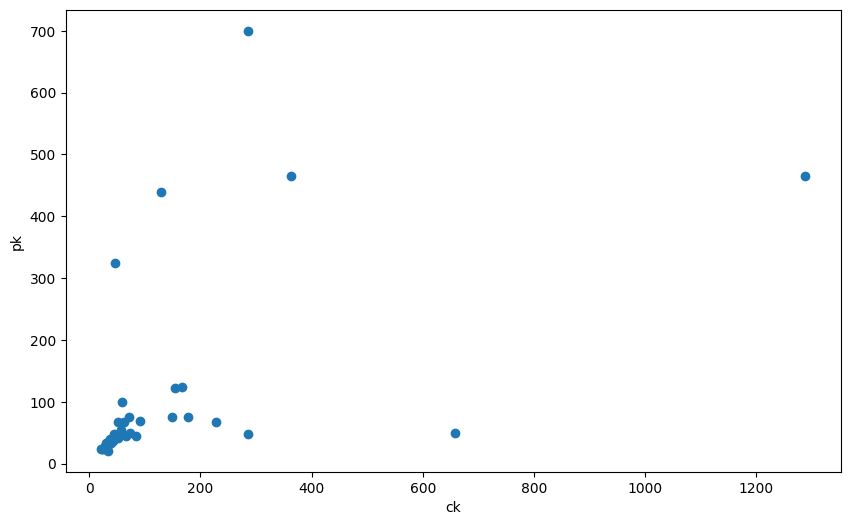

In [29]:
# Gráfica la relación entre ck, pk y la precisión del modelo

# Crear un DataFrame con los resultados
data = {'ck': y_test, 'pk': y_pred}
df = pd.DataFrame(data)

# Crear una gráfica de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df['ck'], df['pk'])
plt.xlabel('ck')
plt.ylabel('pk')
plt.show()